In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.lines as mlines
from scipy.stats import ttest_ind
import re

In [15]:
url = 'https://raw.githubusercontent.com/shakiltonmoy/Python_for_Biologists/refs/heads/main/data_for_Volcano_plot.csv'
df = pd.read_csv(url)
df.head()

,Gene Name,HNOX_1,HNOX_2,HNOX_3,WT_1,WT_2,WT_3
0,Pden_0444,0,0,0,15861000,15839000,15009000
1,ppk,0,0,0,2335300,2519400,2585500
2,Pden_4022,0,0,0,4163000,4203200,3781000
3,Pden_4104,0,0,0,4776700,5177700,4477700
4,Pden_0682,0,0,0,2232800,1855500,2098100


In [16]:
print(df.shape)

(1758, 7)


In [17]:
#Data curation
# Define the columns that need to be converted to numeric
numeric_columns = df.columns[1:].tolist()
print(numeric_columns)

# Convert these columns to numeric, coercing errors to NaN
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

['HNOX_1', 'HNOX_2', 'HNOX_3', 'WT_1', 'WT_2', 'WT_3']


In [18]:
# Calculate mean for WT and DM replicates
df['WT_Mean'] = df[['WT_1', 'WT_2', 'WT_3']].mean(axis=1)
df['HNOX_Mean'] = df[['HNOX_1', 'HNOX_2', 'HNOX_3']].mean(axis=1)

In [19]:
# Calculate log2 fold-change
df['Log2_FC'] = np.log2(df['HNOX_Mean'] / df['WT_Mean'].replace(0, np.nan))

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [20]:
# Perform t-tests (two-sample assuming equal variance)
t_stats, p_values = ttest_ind(
    df[['WT_1', 'WT_2', 'WT_3']].values,
    df[['HNOX_1', 'HNOX_2', 'HNOX_3']].values,
    axis=1, nan_policy='omit'
)

In [21]:
# Add p-values and -log10(p-values) to the DataFrame
df['P_Value'] = p_values
df['MinusLog10_P'] = -np.log10(df['P_Value'])
df_filtered = df[np.isfinite(df['Log2_FC']) & np.isfinite(df['MinusLog10_P'])].copy()

In [22]:
# Define significance thresholds
p_value_threshold = 0.05
log2fc_threshold = 0.58

# Filter for genes that meet both p-value and log2 fold change cutoffs
significant_downregulated = df_filtered[(df_filtered['P_Value'] < p_value_threshold) & (df_filtered['Log2_FC'] < -log2fc_threshold)]
significant_upregulated = df_filtered[(df_filtered['P_Value'] < p_value_threshold) & (df_filtered['Log2_FC'] > log2fc_threshold)]

# Select the top 5 most downregulated and top 5 most upregulated significant genes
# These are selected based on the most extreme Log2_FC values among the significant ones
top_5_downregulated = significant_downregulated.sort_values(by='Log2_FC').head(5)
top_5_upregulated = significant_upregulated.sort_values(by='Log2_FC', ascending=False).head(5)

# Concatenate these top genes for labeling and highlighting in the plot
top_genes = pd.concat([top_5_downregulated, top_5_upregulated])



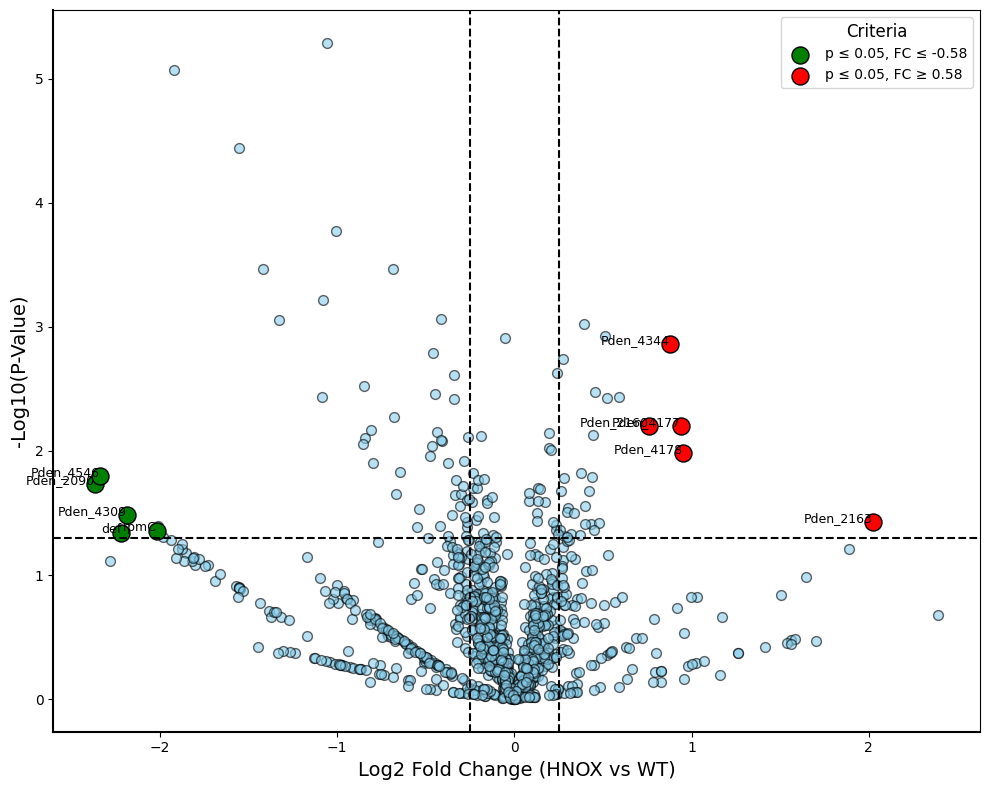

In [24]:
# Separate significant genes for coloring
left_candidates = top_genes[top_genes['Log2_FC'] < 0.58]
right_candidates = top_genes[top_genes['Log2_FC'] > -0.58]

# Create the volcano plot
plt.figure(figsize=(10, 8))
plt.scatter(df_filtered['Log2_FC'], df_filtered['MinusLog10_P'], alpha=0.6, edgecolor='black', marker='o', s=50, color='#87CEEB')
# Highlight significant genes
plt.scatter(left_candidates['Log2_FC'], left_candidates['MinusLog10_P'], color='green', s=150, edgecolor='black', marker='o', label='p ≤ 0.05, FC ≤ -0.58')
plt.scatter(right_candidates['Log2_FC'], right_candidates['MinusLog10_P'], color='red', s=150, edgecolor='black', marker='o', label='p ≤ 0.05, FC ≥ 0.58')

# Add gene labels
for _, row in top_genes.iterrows():
    plt.text(row['Log2_FC'], row['MinusLog10_P'], row['Gene Name'], fontsize=9, ha='right')

# Add reference lines
plt.axhline(-np.log10(0.05), color='black', linestyle='--')
plt.axvline(0.25, color='black', linestyle='--')
plt.axvline(-0.25, color='black', linestyle='--')

# Add a border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Update axis labels and add legend
plt.xlabel('Log2 Fold Change (HNOX vs WT)', fontsize=14)
plt.ylabel('-Log10(P-Value)', fontsize=14)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
# Save the plot as PNG (600 DPI) and PDF
png_path = 'volcano_plot1.png'
pdf_path = 'volcano_plot1.pdf'
plt.savefig(png_path, dpi=600, format='png')
plt.savefig(pdf_path, format='pdf')
plt.tight_layout()
# Show the plot
plt.show()
# Download the files
#files.download(png_path)
#files.download(pdf_path)